## Poisson CS Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures in the first simulation in the paper. 

In this example simulate three fixed effects from $\beta \sim$ rand(Uniform(-2, 2), p) where p = 3 fixed effects.

In this example we have Poisson base distribution with Log Link function and covariance matrix $\Gamma$ structured under CS covariance with $\rho = 0.5, \sigma^2 = 0.5$

We run each scenario 100 times.

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept

# true parameter values
Random.seed!(12345)
βtrue = rand(Uniform(-2, 2), p)
σ2true = [0.5]
ρtrue = [0.5]
θtrue = [ρtrue; σ2true]

# generate data
trueparams = [βtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100

100

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_poisson_CS$(nsims)reps_sim.csv", ','))
σ2MseResult = vec(readdlm("mse_sigma_multivariate_poisson_CS$(nsims)reps_sim.csv", ','))
ρMseResult = vec(readdlm("mse_rho_multivariate_poisson_CS$(nsims)reps_sim.csv", ','))
fittimes = vec(readdlm("fittimes_multivariate_poisson_CS$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
 0.147492497
 0.08251665
 0.076538622
 0.070512139
 0.081820689
 0.088571617
 0.087443364
 0.07567901
 0.104133551
 0.099135193
 0.088639515
 0.092092205
 0.103054608
 ⋮
 4.182530688
 4.474185976
 5.812282558
 4.715524609
 4.795341341
 4.035920662
 5.159700306
 9.87552305
 5.029495806
 4.33042734
 8.226778705
 4.766310319

In [5]:
#simulation parameters
@info "making results table"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

data = hcat(sample_sizes, obs_sizes, fittimes)

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes)
msedf = filter(x -> !isnan(x.fittimes), msedf)

timedf = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf, Dict(:fittimes_function => "se"))
timedf[!, :nobs] = Meta.parse.(timedf[!, :samplesize]) .* Meta.parse.(timedf[!, :obssize])
timedf[!, :fitmin] = timedf[!, :fittime] - timedf[!, :se]
timedf[!, :fitmax] = timedf[!, :fittime] + timedf[!, :se]
timedf[!, :perobsratio] = timedf[!, :fittime] ./ timedf[!, :nobs]
timedf

┌ Info: making results table
└ @ Main In[5]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0852752,0.00266446,200,0.0826107,0.0879397,0.000426376
2,100,5,0.0838005,0.00157631,500,0.0822242,0.0853768,0.000167601
3,100,10,0.134157,0.0114773,1000,0.12268,0.145635,0.000134157
4,100,15,0.242525,0.0240491,1500,0.218476,0.266574,0.000161683
5,100,20,0.310706,0.0282798,2000,0.282427,0.338986,0.000155353
6,100,25,0.397119,0.0312815,2500,0.365837,0.4284,0.000158848
7,1000,2,0.147727,0.00773688,2000,0.13999,0.155464,7.38634e-5
8,1000,5,0.185342,0.00313562,5000,0.182207,0.188478,3.70685e-5
9,1000,10,0.215515,0.00833789,10000,0.207177,0.223853,2.15515e-5


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


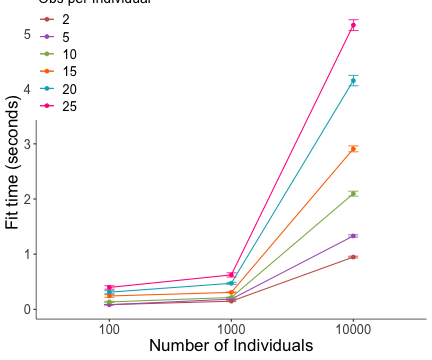

RObject{VecSxp}


In [6]:
########### plot the runtimes
using RCall
@rput timedf

R"""
library(ggplot2)
timedf$obssize = factor(timedf$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf$samplesize = factor(timedf$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")
"""

In [7]:
R"""
    ggsave('fittimes_nobs_poisson_CS_0.5_0.5.png', fittime_1, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittimes_nobs_poisson_CS_0.5_0.5.png"


In [8]:
# using RCall
# @rput timedf

# R"""
# library(scales)
# library(ggplot2)
# timedf$obssize <- factor(timedf$obssize, levels = c('2', '5', '10', '15', '20', '25'))
# timedf$samplesize <- factor(timedf$samplesize, levels = c('100', '1000', '10000'))

# fancy_scientific <- function(l) {
#      # turn in to character string in scientific notation
#      l <- format(l, scientific = TRUE)
#      # quote the part before the exponent to keep all the digits
#      l <- gsub("^(.*)e", "'\\1'e", l)
#      # turn the 'e+' into plotmath format
#      l <- gsub("e", "%*%10^", l)
#      # return this as an expression
#      parse(text=l)
# }

# fittimeperobs = ggplot(timedf, aes(x=nobs, y=perobsratio)) + 
#   geom_line() +
#   geom_point()+
# #  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
#   theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
#         axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
#         axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
#         #axis.ticks = element_blank(),
#         panel.grid.major = element_blank(), legend.text=element_text(size=11),
#         panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
#         axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
#   labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
# #scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
# scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
# scale_y_continuous(breaks = c(10^-4, 2 * 10^-4, 3 * 10^-4, 4 * 10^-4, 5 * 10^-4, 6 * 10^-4), labels= fancy_scientific)

# """

In [9]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βρσ2coverage = readdlm("beta_sigma_coverage_multivariate_poisson_CS$(nsims)reps_sim.csv", ',')

m = 2

covdf = DataFrame(Matrix(transpose(βρσ2coverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p];  ["ρ"]; ["σ2"]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["ρ"];["σ2"]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3
,String,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.52, 0.0502117)","(0.67, 0.0472582)","(0.65, 0.0479372)"
2,N: 100 ni: 5,"(0.44, 0.0498888)","(0.76, 0.0429235)","(0.72, 0.0451261)"
3,N: 100 ni: 10,"(0.46, 0.0500908)","(0.85, 0.035887)","(0.74, 0.0440844)"
4,N: 100 ni: 15,"(0.5125, 0.0500473)","(0.8425, 0.0363511)","(0.6525, 0.0476592)"
5,N: 100 ni: 20,"(0.3725, 0.0483953)","(0.7725, 0.0419076)","(0.6025, 0.0489917)"
6,N: 100 ni: 25,"(0.4225, 0.0494535)","(0.8325, 0.0372771)","(0.7125, 0.045279)"
7,N: 1000 ni: 2,"(0.39, 0.0490207)","(0.8, 0.0402015)","(0.64, 0.0482418)"
8,N: 1000 ni: 5,"(0.48, 0.0502117)","(0.85, 0.035887)","(0.82, 0.0386123)"
9,N: 1000 ni: 10,"(0.44, 0.0498888)","(0.85, 0.035887)","(0.79, 0.040936)"


In [10]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult_1 = vec(readdlm("mse_beta_multivariate_poisson_CS$(nsims)reps_sim.csv", ','))
σ2MseResult_1 = vec(readdlm("mse_sigma_multivariate_poisson_CS$(nsims)reps_sim.csv", ','))
ρMseResult_1 = vec(readdlm("mse_rho_multivariate_poisson_CS$(nsims)reps_sim.csv", ','))
θMseResult_1 = (σ2MseResult_1 .+ ρMseResult_1) ./ 2
βρσ2coverage_1 = readdlm("beta_sigma_coverage_multivariate_poisson_CS$(nsims)reps_sim.csv", ',')

samplesizesrobust = samplesizes
nsrobust = ns
nsimsrobust = nsims

# βMseresultnorm = vec(readdlm("result_files/mse_beta_normal_normal_lognormal_1000reps_sim.csv", ','))
# τMseresultnorm = vec(readdlm("result_files/mse_tau_normal_normal_lognormal_1000reps_sim.csv", ','))
# ΣMseresultnorm = vec(readdlm("result_files/mse_Sigma_normal_normal_lognormal_1000reps_sim.csv", ','))
# βτcoveragenorm = readdlm("result_files/beta_tau_coverage_5betas_normal_normal_lognormal_1000reps_sim.csv", ',')


# samplesizesnorm = collect(1000:1000:6000)
# nsnorm = [10; 25; 50; 100; 1000]
# nsimsnorm = 1000

p = 3
sample_sizesrobust = repeat(string.(samplesizesrobust), inner = nsimsrobust * length(nsrobust))
obs_sizesrobust = repeat(string.(nsrobust), inner = nsimsrobust, outer = length(samplesizesrobust))
msedfrobust = DataFrame(βmse = βMseresult_1, θMse = θMseResult_1,
    samplesize = sample_sizesrobust, obssize = obs_sizesrobust)

msedfrobustR = deepcopy(msedfrobust)
rename!(msedfrobustR, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);


mses = [msedfrobustR[!, :betamse]; msedfrobustR[!, :thetamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = collect([repeat(msedfrobustR[!, :obssize], 2)]...) # ; repeat(msedfnormR[!, :obssize], 3)]

samplesize = collect([repeat(msedfrobustR[!, :samplesize], 2)]...) # ; repeat(msedfnormR[!, :samplesize], 3)]

parameters = collect([repeat(string.([:beta, :theta]), inner = nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...)
# ; repeat(string.([:beta, :tau, :Sigma]), inner = nsimsnorm * length(nsnorm) * length(samplesizesnorm))]
robust = collect([repeat(["Poisson CS with LogLink"], 2 * nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...) # ;
# repeat(["Normal Normal Log-Normal"], 3 * nsimsnorm * length(nsnorm) * length(samplesizesnorm))];

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.00329795,2,100,beta,Poisson CS with LogLink
2,0.000413822,2,100,beta,Poisson CS with LogLink
3,0.00468774,2,100,beta,Poisson CS with LogLink
4,0.0029853,2,100,beta,Poisson CS with LogLink
5,0.000582128,2,100,beta,Poisson CS with LogLink
6,0.000694845,2,100,beta,Poisson CS with LogLink
7,0.00170186,2,100,beta,Poisson CS with LogLink
8,0.000276654,2,100,beta,Poisson CS with LogLink
9,0.0020291,2,100,beta,Poisson CS with LogLink


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


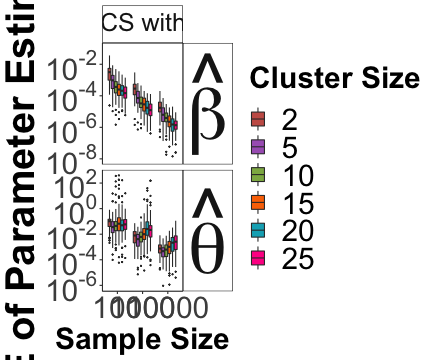

RObject{VecSxp}


In [11]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-8]
msedfR[parameters == "beta",y_max := 10^-1]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta)))))
msedfR$robust = factor(msedfR$robust, levels = c('Poisson CS with LogLink'),
    labels = c(expression(paste("Poisson CS with LogLink")))) # , expression(paste("MvT Gamma Inverse-Gamma"))))

#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 
"""

In [12]:
R"""
    ggsave('updated_msefacetplot_poisson_CS_rho_0.5_0.5.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_poisson_CS_rho_0.5_0.5.png"
